In [456]:
!pip install scikit-learn
!pip install skccm

In [29]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore')
import matplotlib.pyplot as plt


def collect_log_data(file_name):
    """
    Parses log data for PlayerLog
    Breaks in episode by detecting Score
    """
    lines = []
    scores = []
    with open("../"+file_name, "rt") as fh:
        episode=0
        step=0
        for line in fh:
            if line.startswith("PlayerLog"):
                item = line.strip().replace("PlayerLog: ","").split("position")
                if len(item) == 2:
                    agent, coords = item
                    x,z,y=coords.strip().replace("is: ","").strip("()").replace(" ","").split(",")
                    lines.append([agent.strip(), x, y, (float(x),float(y)), step, episode])
                    step+=1
                else:
                    if "Scored" in item[0]:
                        scores.append(item[0])
                        episode+=1
                        step=0
                    
    return lines, scores

def write_log_data(file_name):
    try:
        lines, scores = collect_log_data(file_name)                 
        df_poca = make_games_df(lines)
        df_scores_poca = pd.DataFrame(zip(range(len(scores)), scores), columns=['episode','score'])

        df_poca.to_csv(file_name.replace(".log","")+"_AgentGameData.csv")
        df_scores_poca.to_csv(file_name.replace(".log","")+"_AgentScoresData.csv")
        return "Done"
    except FileNotFoundError:
        print(f"no log data found for {file_name}")




def make_games_df(lines):
    df = pd.DataFrame(lines, columns=['agent','x','y','pos','step','episode'])
    df = df.set_index("agent")
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    return df

def plot_a_game(df, game, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    df.query(f"episode == {game}").loc['Ball'].tail(3).plot.line(x="x", y="y", label="Ball", c='black', ax=ax)
    df.query(f"episode == {game}").loc['Ball'].plot.scatter(x="x", y="y", label="Ball", c='black', ax=ax)
    df.query(f"episode == {game}").loc['Blue Agent1'].plot.scatter(x="x", y="y", label="BlueTeamAgent1", c='lightblue', ax=ax)
    df.query(f"episode == {game}").loc['Blue Agent2'].plot.scatter(x="x", y="y", label="BlueTeamAgent2", c='blue', ax=ax)
    df.query(f"episode == {game}").loc['Purple Agent1'].plot.scatter(x="x", y="y", label="RedTeamAgent1", c='orchid', ax=ax)
    df.query(f"episode == {game}").loc['Purple Agent2'].plot.scatter(x="x", y="y", label="RedTeamAgent2", c='purple', ax=ax)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.1, 1.05))


def distance(item):
    pos1, pos2=item[0], item[1]
    return np.sqrt( (pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)

import skccm as ccm

from skccm.utilities import train_test_split

def embed(x1, x2, lag=2, embed=2):
    e1 = ccm.Embed(x1)
    e2 = ccm.Embed(x2)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    return X1, X2

def forecast_skill(embedding, percent=0.75):
    X1, X2 = embedding
    #split the embedded time series 
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=percent)

    CCM = ccm.CCM() #initiate the class

    #library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

    #test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

    sc1,sc2 = CCM.score()
    return pd.DataFrame(zip(sc1, sc2), columns=['sc1','sc2'])

def collect_distances_per_episode(df, scores):
    df_cp = df.copy().reset_index()
    df_cp['pos'] = list(zip(df_cp['x'], df_cp['y']))
    blue_distance_dfs = []
    purple_distance_dfs = []
    for i in range(len(scores)-1):
        episode = i
        ba1_pos = df_cp[df_cp['agent'].isin(['Blue Agent1'])].query(f"episode == {episode}")['pos'].tolist()
        ba2_pos = df_cp[df_cp['agent'].isin(['Blue Agent2'])].query(f"episode == {episode}")['pos'].tolist()
        ra1_pos = df_cp[df_cp['agent'].isin(['Purple Agent1'])].query(f"episode == {episode}")['pos'].tolist()
        ra2_pos = df_cp[df_cp['agent'].isin(['Purple Agent2'])].query(f"episode == {episode}")['pos'].tolist()
        df_blue = pd.DataFrame(list(map(distance, zip(ba1_pos, ba2_pos))),columns=['BlueTeam'])
        df_purple = pd.DataFrame(list(map(distance, zip(ra1_pos, ra2_pos))),columns=['PurpleTeam'])
        if 'Blue' in scores[episode]:
            df_blue['blue_team_scored'] = 1
            df_purple['purple_team_scored'] = 0
        else:
            df_blue['blue_team_scored'] = 0
            df_purple['purple_team_scored'] = 1
        df_blue['episode'] = episode
        df_purple['episode'] = episode
        df_blue.loc[df_blue.shape[0]-1, 'is_final_step'] = 1
        df_purple.loc[df_purple.shape[0]-1, 'is_final_step'] = 1
        blue_distance_dfs.append(df_blue)
        purple_distance_dfs.append(df_purple)
    blue_distance_df=pd.concat(blue_distance_dfs)
    blue_distance_df = blue_distance_df.fillna(0)
    purple_distance_df=pd.concat(purple_distance_dfs)
    purple_distance_df = purple_distance_df.fillna(0)

    df_distances = pd.DataFrame(range(len(scores)-1), columns=['episode']).merge(purple_distance_df.query("is_final_step == 1").drop(columns=['is_final_step']), how="left")
    df_distances = df_distances.merge(blue_distance_df.query("is_final_step == 1").drop(columns=['is_final_step']), how="left") 
    return df_distances

def collect_forecasts(df, scores):
    results_forecast = []
    for episode_n in range(len(scores)-1):
        
        x1 = df.query(f"episode =={episode_n} & agent == 'Blue Agent1'")["x"].values
        x2 = df.query(f"episode == {episode_n} & agent == 'Blue Agent2'")["x"].values   
        if len(x1) > 20:
            forecast = forecast_skill(embed(x1, x2))
            max_forecast = forecast.max().max()
            mean_forecast = forecast.mean().max()
            results_forecast.append([episode_n, max_forecast, mean_forecast])
    df_results_forecast = pd.DataFrame(results_forecast, columns=['episode', 'max_skill', 'mean_skill'])
    return df_results_forecast
    
file_name_poca = "POCA_LastCheckpoint.log"
file_name_poca_ck1 = "POCA_Checkpoint1.log"
file_name_poca_hf = "POCA_HalfTrained_lr.log"
file_name_ppo = "PPO_LastCheckpoint.log"
file_name_poca_bs100k = "POCA_bs100000.log"
file_name_poca_bs50k = "POCA_bs50000.log"  

all_files = [
    file_name_poca_bs100k,
    file_name_poca_bs50k,
    file_name_poca,
    file_name_poca_ck1,
    file_name_poca_hf,
    file_name_ppo
    ]

[write_log_data(f) for f in all_files]




no log data found for POCA_bs100000.log
no log data found for POCA_LastCheckpoint.log
no log data found for POCA_Checkpoint1.log
no log data found for POCA_HalfTrained_lr.log
no log data found for PPO_LastCheckpoint.log


[None, 'Done', None, None, None, None]

In [30]:
import glob
print(glob.glob("*_AgentGameData.csv"))
poca_bs100k_df = pd.read_csv('POCA_bs100000_AgentGameData.csv')
poca_bs100k_scores = pd.read_csv('POCA_bs100000_AgentScoresData.csv')['score'].tolist()

poca_bs50k_df = pd.read_csv('POCA_bs50000_AgentGameData.csv')
poca_bs50k_scores = pd.read_csv('POCA_bs50000_AgentScoresData.csv')['score'].tolist()

poca_full_df = pd.read_csv('POCA_LastCheckpoint_AgentGameData.csv')
poca_full_scores = pd.read_csv('POCA_LastCheckpoint_AgentScoresData.csv')['score'].tolist()

poca_half_df = pd.read_csv('POCA_HalfTrained_lr_AgentGameData.csv')
poca_half_scores = pd.read_csv('POCA_HalfTrained_lr_AgentScoresData.csv')['score'].tolist()

ppo_full_df = pd.read_csv('PPO_LastCheckpoint_AgentGameData.csv')
ppo_full_scores = pd.read_csv('PPO_LastCheckpoint_AgentScoresData.csv')['score'].tolist()

['POCA_bs100000_AgentGameData.csv', 'POCA_bs50000_AgentGameData.csv', 'POCA_Checkpoint1_AgentGameData.csv', 'POCA_HalfTrained_lr_AgentGameData.csv', 'POCA_LastCheckpoint_AgentGameData.csv', 'PPO_LastCheckpoint_AgentGameData.csv']


In [43]:

df_distances_poca_bs100k = collect_distances_per_episode(poca_bs100k_df, poca_bs100k_scores)
df_results_forecast_poca_bs100k = collect_forecasts(poca_bs100k_df, poca_bs100k_scores)

df_distances_poca_bs50k = collect_distances_per_episode(poca_bs50k_df, poca_bs50k_scores)
df_results_forecast_poca_bs50k = collect_forecasts(poca_bs50k_df, poca_bs50k_scores)

df_distances_poca = collect_distances_per_episode(poca_full_df, poca_full_scores)
df_results_forecast_poca = collect_forecasts(poca_full_df, poca_full_scores)

df_distances_hpoca = collect_distances_per_episode(poca_half_df, poca_half_scores)
df_results_forecast_hpoca = collect_forecasts(poca_half_df, poca_half_scores)

df_distances_ppo = collect_distances_per_episode(ppo_full_df, ppo_full_scores)
df_results_forecast_ppo = collect_forecasts(ppo_full_df, ppo_full_scores)

/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: in

In [44]:
df_results_forecast_poca_bs100k = df_results_forecast_poca_bs100k.rename(columns={"max_skill":"max_skill_pocaBS100k","mean_skill":"mean_skill_pocaBS100k"})
df_results_forecast_poca_bs50k = df_results_forecast_poca_bs50k.rename(columns={"max_skill":"max_skill_pocaBS50k","mean_skill":"mean_skill_pocaBS50k"})
df_results_forecast_poca = df_results_forecast_poca.rename(columns={"max_skill":"max_skill_poca","mean_skill":"mean_skill_poca"})
df_results_forecast_hpoca = df_results_forecast_hpoca.rename(columns={"max_skill":"max_skill_hpoca","mean_skill":"mean_skill_hpoca"})
df_results_forecast_ppo = df_results_forecast_ppo.rename(columns={"max_skill":"max_skill_ppo","mean_skill":"mean_skill_ppo"})

Text(0.5, 0, 'Average Forecast Skill per game')

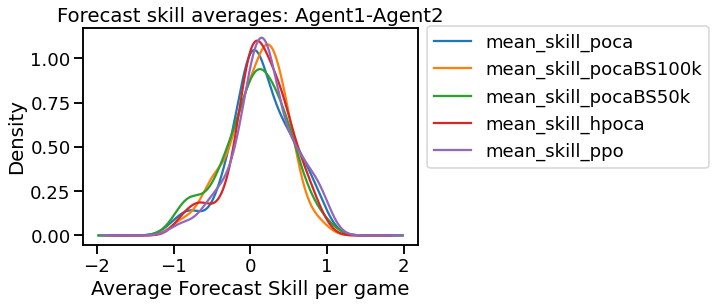

In [45]:
df_skills_mean = df_results_forecast_poca.merge(
    df_results_forecast_hpoca).merge(
        df_results_forecast_ppo).merge(
            df_results_forecast_poca_bs100k).merge(
                df_results_forecast_poca_bs50k)[['mean_skill_poca','mean_skill_pocaBS100k','mean_skill_pocaBS50k','mean_skill_hpoca','mean_skill_ppo']]
df_skills_mean.plot.density()
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("Forecast skill averages: Agent1-Agent2")
plt.xlabel("Average Forecast Skill per game")

In [46]:
df_skills_mean.describe()

,mean_skill_poca,mean_skill_pocaBS100k,mean_skill_pocaBS50k,mean_skill_hpoca,mean_skill_ppo
count,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.125986,0.089330,0.069187,0.134640,0.178504
std,0.415532,0.380544,0.430573,0.387974,0.401491
min,-0.984812,-0.954935,-0.990813,-0.902671,-0.961470
25%,-0.079328,-0.142715,-0.157282,-0.050743,-0.024876
50%,0.098991,0.145089,0.103162,0.140157,0.176366
75%,0.408579,0.363313,0.371788,0.407914,0.424795
max,0.992838,0.926380,0.991969,0.922357,0.999386


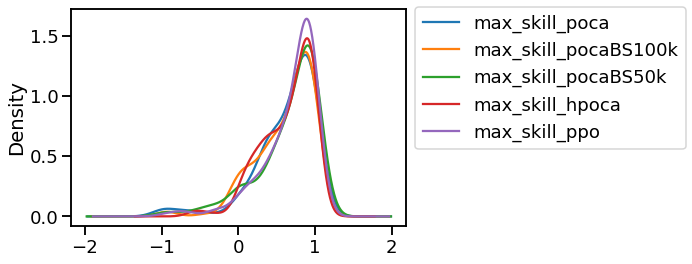

In [47]:
df_skills_max = df_results_forecast_poca.merge(
    df_results_forecast_hpoca).merge(
        df_results_forecast_ppo).merge(
            df_results_forecast_poca_bs100k).merge(
                df_results_forecast_poca_bs50k)[['max_skill_poca','max_skill_pocaBS100k','max_skill_pocaBS50k','max_skill_hpoca','max_skill_ppo']]
df_skills_max.plot.density()
plt.legend(bbox_to_anchor=(1, 1.05))

In [48]:
df_skills_max.describe()

,max_skill_poca,max_skill_pocaBS100k,max_skill_pocaBS50k,max_skill_hpoca,max_skill_ppo
count,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.623234,0.611651,0.644680,0.638757,0.675372
std,0.406716,0.372704,0.410883,0.331116,0.361124
min,-0.978974,-0.942972,-0.986221,-0.567341,-0.931338
25%,0.416091,0.392379,0.505134,0.413381,0.528202
50%,0.745723,0.739499,0.808060,0.730837,0.808608
75%,0.922330,0.921803,0.951314,0.924754,0.929917
max,0.999810,0.998803,0.998563,0.995501,0.999581


In [102]:
from scipy import stats

def kl_distance_teams(df):
    df_ds1 = df.query("blue_team_scored == 0")
    m1 = abs(df_ds1['PurpleTeam'].mean() - df_ds1['BlueTeam'].mean())
    kld1 = stats.entropy(df_ds1['PurpleTeam'], df_ds1['BlueTeam'])
    df_ds2 = df.query("blue_team_scored == 1")
    kld2 = stats.entropy(df_ds2['PurpleTeam'], df_ds2['BlueTeam'])
    m2 = abs(df_ds2['PurpleTeam'].mean() - df_ds2['BlueTeam'].mean())
    return np.mean([kld1, kld2]).round(2), np.mean([m1, m2]).round(2)

df_dist_res =pd.DataFrame(
    dict(
        ppo=kl_distance_teams(df_distances_ppo),
        poca=kl_distance_teams(df_distances_poca),
        pocaBS100k=kl_distance_teams(df_distances_poca_bs100k),
        pocaBS50k=kl_distance_teams(df_distances_poca_bs50k),
        hpoca=kl_distance_teams(df_distances_hpoca)
    )).T
df_dist_res.columns=['KLD','abs_diff']
df_dist_res

,KLD,abs_diff
ppo,0.35,4.57
poca,0.26,2.46
pocaBS100k,0.26,3.27
pocaBS50k,0.32,1.82
hpoca,0.46,2.42


In [110]:
df_sk_ = df_skills_mean.mean()
df_sk_.index = df_sk_.index.str.replace("mean_skill_","")
df_sk = pd.DataFrame(df_sk_)
df_sk.columns=['mean_skill']
df_comb_res = df_dist_res.join(df_sk)

In [116]:
df_comb_res.sort_values("mean_skill")

,KLD,abs_diff,mean_skill
pocaBS50k,0.32,1.82,0.069187
pocaBS100k,0.26,3.27,0.089330
poca,0.26,2.46,0.125986
hpoca,0.46,2.42,0.134640
ppo,0.35,4.57,0.178504


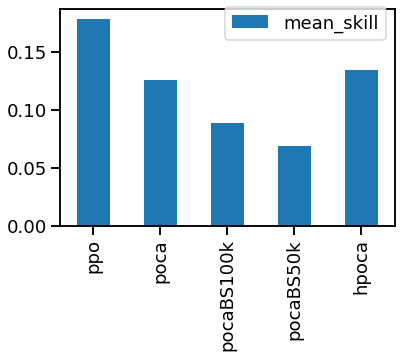

In [125]:
df_comb_res['mean_skill'].plot.bar()
plt.legend(bbox_to_anchor=(1, 1.05))

In [50]:
df_distances_ppo

,episode,PurpleTeam,purple_team_scored,BlueTeam,blue_team_scored
0,0,4.403862,1,6.713337,0
1,1,21.372508,1,21.840037,0
2,2,2.412488,0,12.688018,1
3,3,10.154216,0,13.720835,1
4,4,10.796856,0,8.639450,1
...,...,...,...,...,...
320,320,14.496734,1,6.932395,0
321,321,14.702884,1,6.900790,0
322,322,12.326597,0,12.665895,1
323,323,4.565140,1,10.207311,0


Text(0.5, 1.0, 'POCA BS100k')

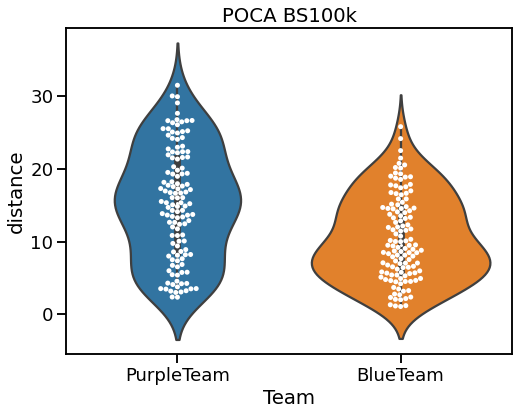

In [123]:
import seaborn as sns
sns.set_context("talk", font_scale=1.1)
df_plot = df_distances_poca_bs100k.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 1")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")
plt.title("POCA BS100k")                  

Text(0.5, 1.0, 'PPO')

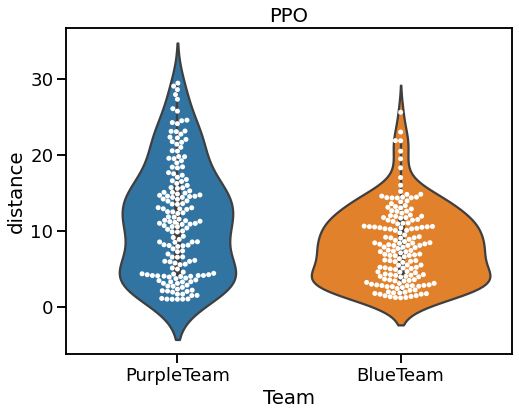

In [118]:
import seaborn as sns
sns.set_context("talk", font_scale=1.1)
df_plot = df_distances_ppo.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 1")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")
plt.title("PPO")                  

Text(0.5, 1.0, 'PPO')

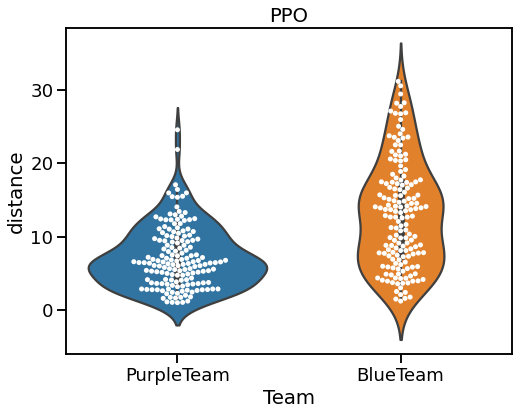

In [119]:
import seaborn as sns
#sns.set_context("talk", font_scale=1.1)
df_plot = df_distances_ppo.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 0")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")

plt.title("PPO") 

Text(0.5, 1.0, 'POCA')

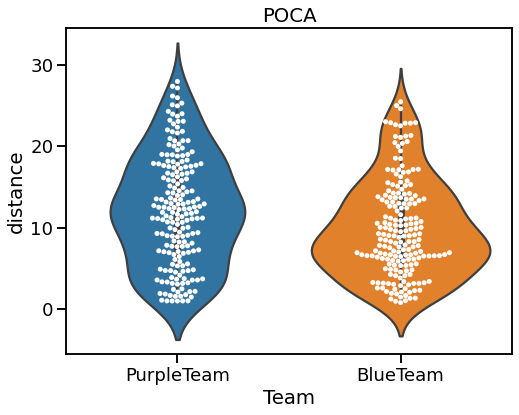

In [120]:
import seaborn as sns
sns.set_context("talk", font_scale=1.1)
df_plot = df_distances_poca.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 1")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")
plt.title("POCA")                  

Text(0.5, 1.0, 'POCA')

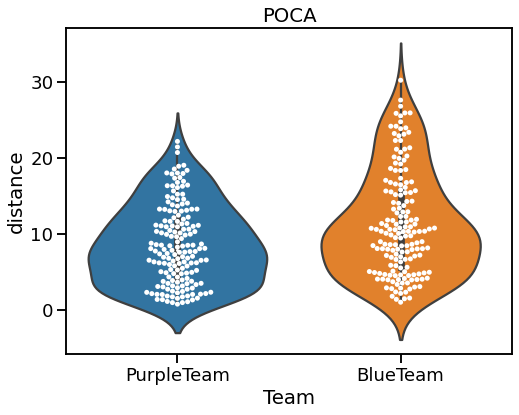

In [121]:
import seaborn as sns
#sns.set_context("talk", font_scale=1.1)
df_plot = df_distances_poca.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 0")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")

plt.title("POCA") 

Text(0.5, 1.0, 'POCA BS100k')

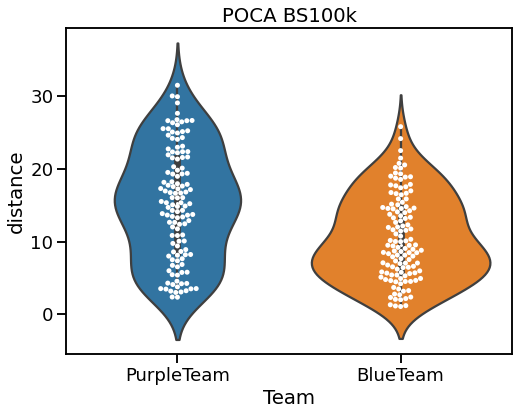

In [122]:
import seaborn as sns
sns.set_context("talk", font_scale=1.1)
df_plot = df_distances_poca_bs100k.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 1")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")
plt.title("POCA BS100k")                  

Text(0.5, 1.0, 'Blue Team Scored')

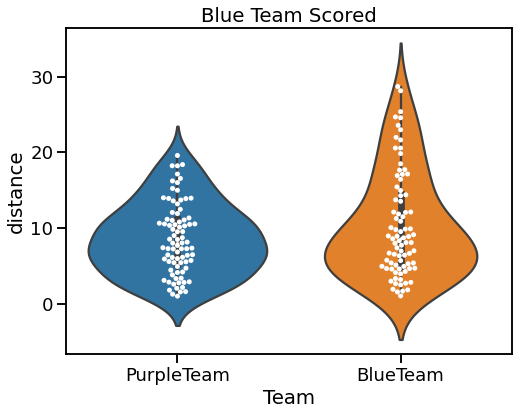

In [14]:
import seaborn as sns
#sns.set_context("talk", font_scale=1.1)
df_plot = df_distances_poca_bs100k.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 0")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")

plt.title("Blue Team Scored") 

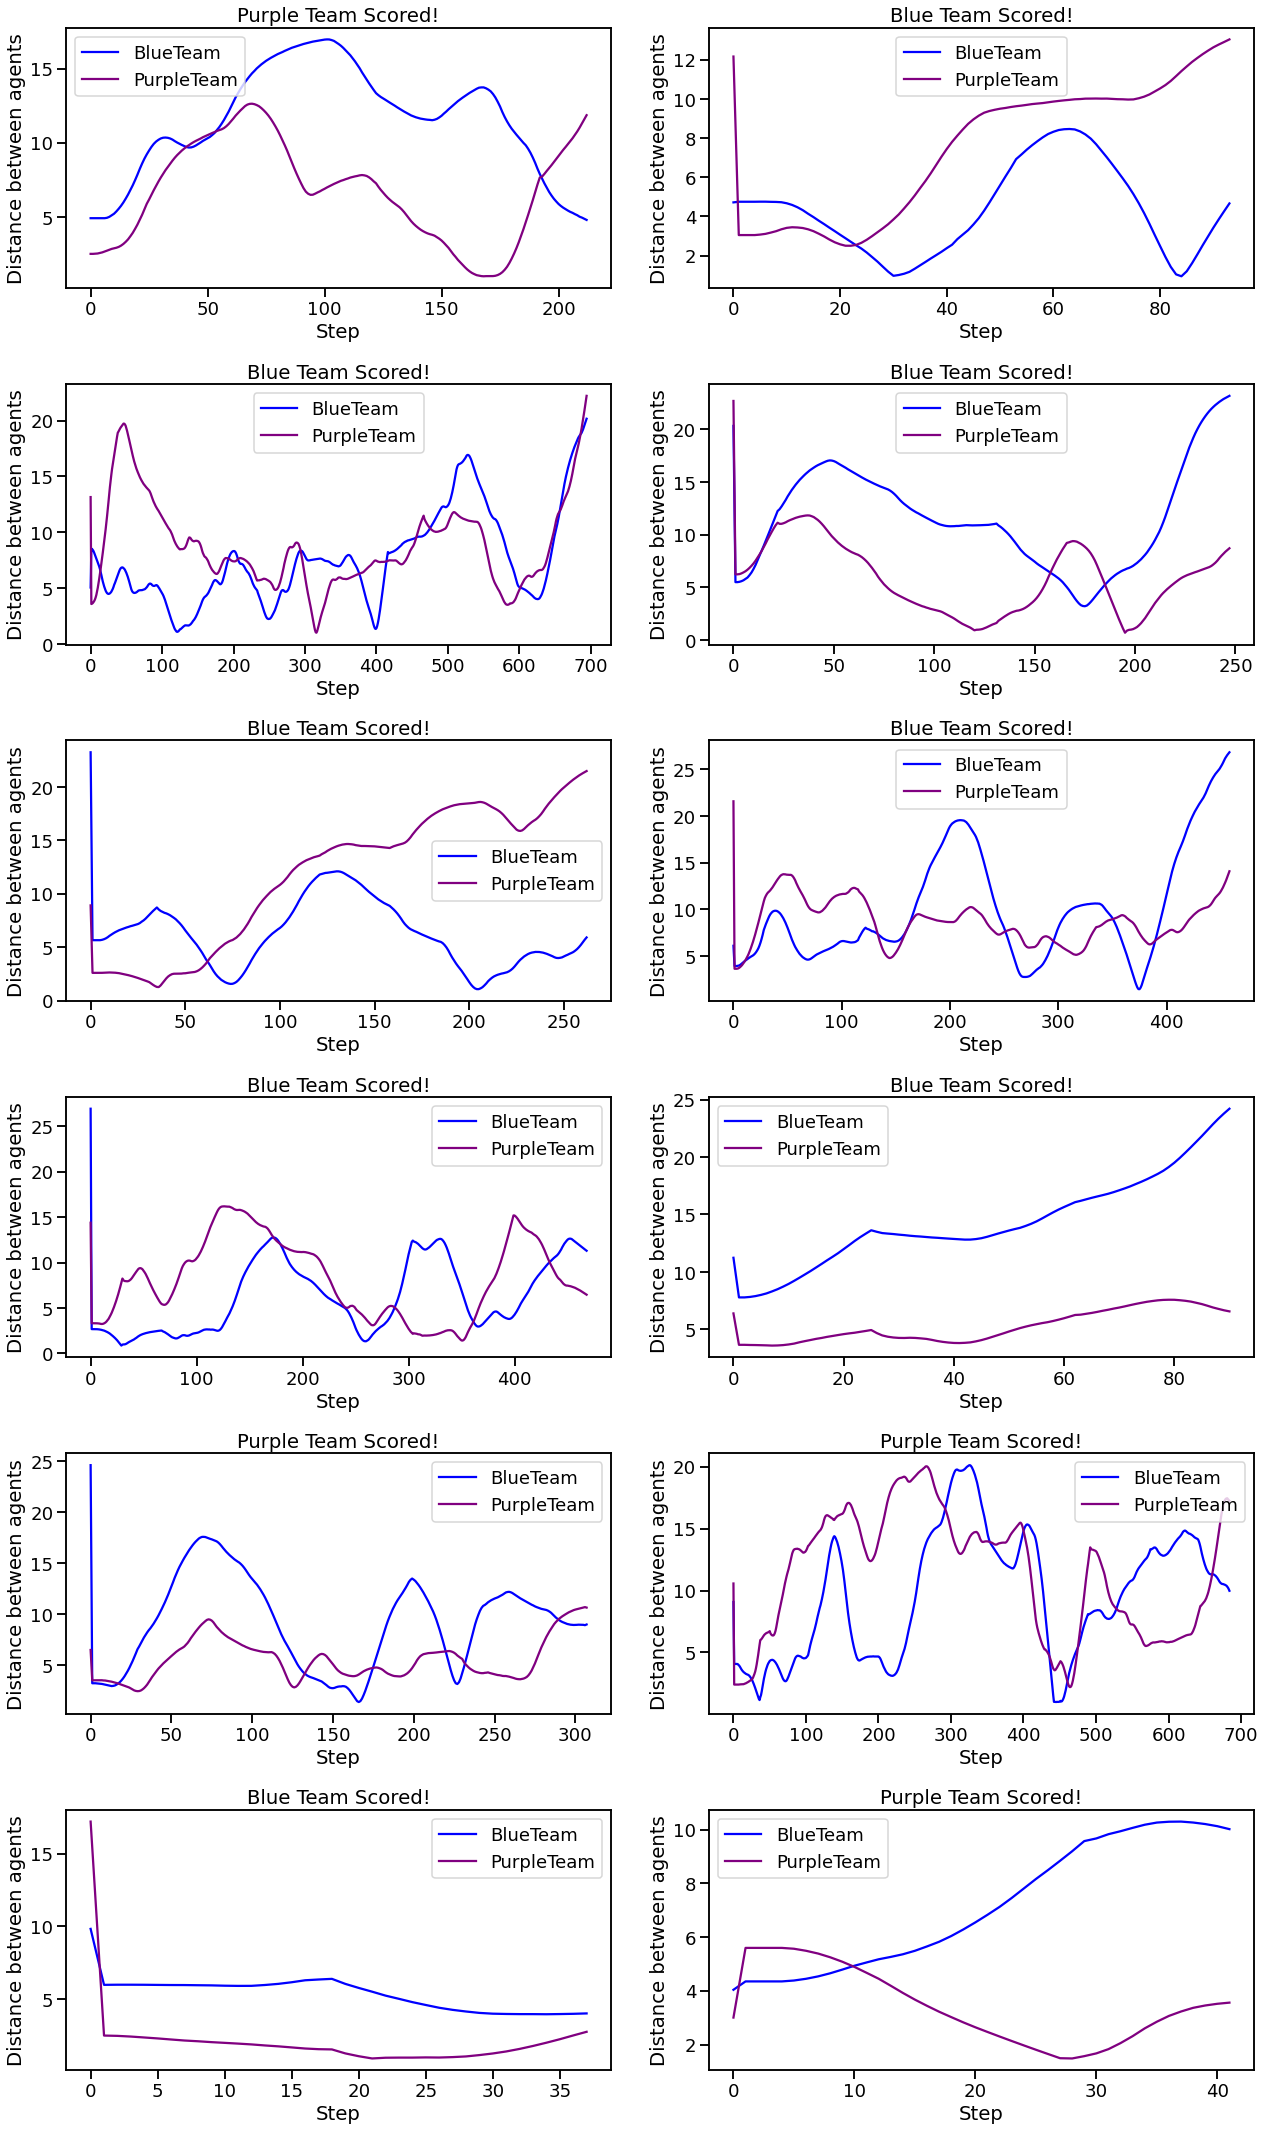

Text(0.5, 1.0, 'Purple Team Scored!')

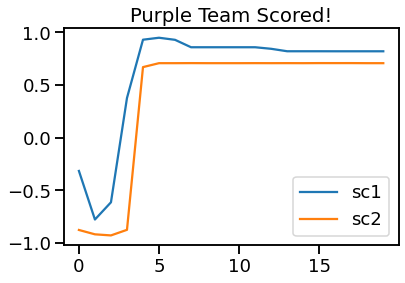

In [394]:
episode_n = 0
x1 = df_results_forecast_poca.query(f"episode =={episode_n} & agent == 'Blue Agent1'")["x"].values
x2 = df_results_forecast_poca.query(f"episode == {episode_n} & agent == 'Blue Agent2'")["x"].values

forecast = forecast_skill(embed(x1, x2))
forecast.plot()
plt.title(poca_full_scores[episode_n])

<AxesSubplot:>

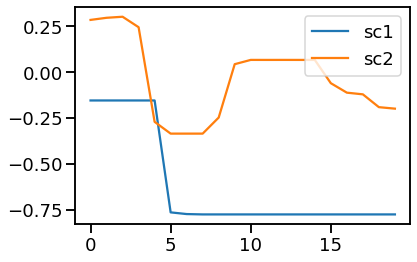

In [395]:
episode_n = 1
x1 = poca_full_scores.query(f"episode =={episode_n} & agent == 'Purple Agent1'")["x"].values
x2 = poca_full_scores.query(f"episode == {episode_n} & agent == 'Purple Agent2'")["x"].values

forecast = forecast_skill(embed(x1, x2))
forecast.plot()